In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sqlite3, pandas as pd
import matplotlib.pyplot as plt
import fasttext
from sklearn.feature_extraction.text import TfidfVectorizer
import json

pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', '{:.2f}'.format)

# Connect to SQLite database
DB_PATH = "drive/MyDrive/Masters Documents/IS5126 Hands on with Applied Analytics/Assignment1/reviews_sample.db"
conn = sqlite3.connect(DB_PATH)

print(f"Connected to {DB_PATH}")

# load the pre-trained model
model = fasttext.load_model('lid.176.ftz')

def get_language(text):
    # FastText handles newlines poorly; cleaning is recommended
    text = str(text).replace("\n", " ")
    # k=1 gives the top prediction
    predictions = model.predict(text, k=1)
    # Extract label (e.g., '__label__en' -> 'en')
    return predictions[0][0].replace('__label__', '')

Connected to drive/MyDrive/Masters Documents/IS5126 Hands on with Applied Analytics/Assignment1/reviews_sample.db


In [ ]:
# Quick check: available tables
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table'", conn)
print("Available tables:")
print(tables)

Available tables:
              name
0  sqlite_sequence
1          authors
2           hotels
3          reviews


In [ ]:
pd.read_sql("""select * from authors limit 1""", conn)

,auhtor_no,author_id,author_name,author_location,author_num_reviews,author_num_cities,author_num_helpful_votes,author_num_type_reviews
0,1,8C0B42FF3C0FA366A21CFD785302A032,Papa_Panda,Gold Coast,29,22,12,24


In [ ]:
pd.read_sql("""select * from hotels limit 1""", conn)

,offering_id
0,72572


In [ ]:
pd.read_sql("""select * from reviews limit 1""", conn)

,id,author_no,author_id,offering_id,overall,service,cleanliness,value,location_rating,sleep_quality,rooms,title,text,review_date,date_stayed,via_mobile,author_num_helpful_votes
0,11676795,None,1BC33D747AFD41207DDF1B30389F2D06,93466,5.00,4.00,4.00,3.00,4.00,None,4.00,“It was great!”,At check in the staff were very nice and offer...,2007-12-25 00:00:00,December 2007,0,10


In [ ]:
df = pd.read_sql("""select * from reviews""", conn)
df.head()

,id,author_no,author_id,offering_id,overall,service,cleanliness,value,location_rating,sleep_quality,rooms,title,text,review_date,date_stayed,via_mobile,author_num_helpful_votes
0,11676795,None,1BC33D747AFD41207DDF1B30389F2D06,93466,5.00,4.00,4.00,3.00,4.00,NaN,4.00,“It was great!”,At check in the staff were very nice and offer...,2007-12-25 00:00:00,December 2007,0,10.00
1,11703779,None,2E16868E5A8347E563556F0691E0CF20,83489,1.00,1.00,3.00,1.00,3.00,NaN,2.00,“I wouldn't recommend this one...”,A friend and I stayed at this hotel for a rece...,2007-12-20 00:00:00,December 2007,0,1.00
2,11704360,None,6A157001884A4B2AB61F56F785F8B3F9,119601,5.00,5.00,5.00,5.00,5.00,NaN,5.00,“So Quiet! So Friendly!”,"Our stay was so quiet, we were very surprised!...",2007-12-20 00:00:00,November 2007,0,3.00
3,11705348,None,E8754ED06F958B342C00B1AD33884360,126257,3.00,3.00,4.00,5.00,5.00,NaN,2.00,“Great location - decent BUDGET hotel”,The location is superb. \nJust a few blocks aw...,2007-12-20 00:00:00,December 2007,0,35.00
4,11705477,None,8445910D017299B5414EF873A2E4ED57,99365,1.00,NaN,NaN,NaN,NaN,NaN,NaN,“Housekeepers steal!”,Do not stay at this hotel!!! I had my ipod sto...,2007-12-20 00:00:00,December 2007,0,1.00


In [ ]:
print(df["review_date"].min(), df["review_date"].max()) # don't need to filter by date since requirement is 5 years

2007-12-20 00:00:00 2012-12-20 00:00:00


In [ ]:
# start by selecting columns that will be used in this assignment
df = df[["offering_id", "overall", "service", "cleanliness", "value", "location_rating",
         "sleep_quality", "rooms", "title", "text", "review_date", "date_stayed", "author_num_helpful_votes"]]
df

,offering_id,overall,service,cleanliness,value,location_rating,sleep_quality,rooms,title,text,review_date,date_stayed,author_num_helpful_votes
0,93466,5.00,4.00,4.00,3.00,4.00,NaN,4.00,“It was great!”,At check in the staff were very nice and offer...,2007-12-25 00:00:00,December 2007,10.00
1,83489,1.00,1.00,3.00,1.00,3.00,NaN,2.00,“I wouldn't recommend this one...”,A friend and I stayed at this hotel for a rece...,2007-12-20 00:00:00,December 2007,1.00
2,119601,5.00,5.00,5.00,5.00,5.00,NaN,5.00,“So Quiet! So Friendly!”,"Our stay was so quiet, we were very surprised!...",2007-12-20 00:00:00,November 2007,3.00
3,126257,3.00,3.00,4.00,5.00,5.00,NaN,2.00,“Great location - decent BUDGET hotel”,The location is superb. \nJust a few blocks aw...,2007-12-20 00:00:00,December 2007,35.00
4,99365,1.00,NaN,NaN,NaN,NaN,NaN,NaN,“Housekeepers steal!”,Do not stay at this hotel!!! I had my ipod sto...,2007-12-20 00:00:00,December 2007,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
754793,115754,4.00,3.00,4.00,4.00,4.00,NaN,5.00,“全套房酒店”,这家是全套房酒店，因此每件房间都会有起居室和卧室，适合常住的商务客。酒店离西雅图的购物区比较...,2012-12-18 00:00:00,common_month_year0,NaN
754794,124186,2.00,1.00,1.00,4.00,1.00,NaN,1.00,“Horrid”,Sheets had six stains on them. Floors were dir...,2012-12-20 00:00:00,December 2012,1.00
754795,111441,4.00,4.00,5.00,4.00,5.00,5.00,5.00,“Great Location in Downtown Boston”,Visited Boston on Dec 16-17 and stay at Hyatt ...,2012-12-20 00:00:00,December 2012,20.00
754796,112132,5.00,5.00,5.00,5.00,5.00,5.00,5.00,“Fabulous hotel and even better customer servi...,"Even though I live in the city, I surprised my...",2012-12-20 00:00:00,December 2012,NaN


In [ ]:
# since requirement is 50-80k rows when the dataset is 750k rows, we can afford to be picky here
# only retain rows that are populated for all our columns
df = df.dropna()
df

,offering_id,overall,service,cleanliness,value,location_rating,sleep_quality,rooms,title,text,review_date,date_stayed,author_num_helpful_votes
147732,93470,1.00,1.00,1.00,1.00,3.00,1.00,1.00,"“Noisy, bug bites, poor furnishings, tiny”",I have traveled for business and stayed at the...,2010-02-01 00:00:00,November 2009,1.00
147733,94326,4.00,5.00,5.00,4.00,4.00,4.00,4.00,“Nice find in Boston”,"After reading past reviews, I wasn't quite sur...",2010-02-01 00:00:00,January 2010,88.00
147734,93352,5.00,5.00,5.00,4.00,5.00,5.00,5.00,“BEST”,Great location and I was wondering if I would ...,2010-02-01 00:00:00,October 2009,25.00
147735,93358,2.00,1.00,1.00,3.00,5.00,1.00,1.00,“Not what we really expected”,I'd found out about this hotel ages before boo...,2010-02-01 00:00:00,January 2010,25.00
147737,84113,5.00,5.00,5.00,5.00,5.00,5.00,5.00,“Above and Beyond what you'd normally expect”,Right away we were impressed with this hotel. ...,2010-02-01 00:00:00,January 2010,31.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
754783,84137,4.00,4.00,4.00,5.00,5.00,5.00,3.00,“Excellent location”,Location: The location was very good as it was...,2012-12-20 00:00:00,August 2012,11.00
754784,120056,5.00,5.00,5.00,5.00,5.00,5.00,5.00,“A Kimpton Classic”,The Monaco in Denver epitomizes the Kimpton ae...,2012-12-20 00:00:00,December 2012,10.00
754791,94330,4.00,4.00,4.00,3.00,4.00,4.00,4.00,"“Nice area, and stay”",I stayed at the Seaport for a night as our com...,2012-12-20 00:00:00,December 2012,5.00
754795,111441,4.00,4.00,5.00,4.00,5.00,5.00,5.00,“Great Location in Downtown Boston”,Visited Boston on Dec 16-17 and stay at Hyatt ...,2012-12-20 00:00:00,December 2012,20.00


In [ ]:
# since we are ultimately modeling the text column for potential improvements
# drop any rows with duplicated text
df = df.drop_duplicates(subset=['text'])
df

,offering_id,overall,service,cleanliness,value,location_rating,sleep_quality,rooms,title,text,review_date,date_stayed,author_num_helpful_votes
147732,93470,1.00,1.00,1.00,1.00,3.00,1.00,1.00,"“Noisy, bug bites, poor furnishings, tiny”",I have traveled for business and stayed at the...,2010-02-01 00:00:00,November 2009,1.00
147733,94326,4.00,5.00,5.00,4.00,4.00,4.00,4.00,“Nice find in Boston”,"After reading past reviews, I wasn't quite sur...",2010-02-01 00:00:00,January 2010,88.00
147734,93352,5.00,5.00,5.00,4.00,5.00,5.00,5.00,“BEST”,Great location and I was wondering if I would ...,2010-02-01 00:00:00,October 2009,25.00
147735,93358,2.00,1.00,1.00,3.00,5.00,1.00,1.00,“Not what we really expected”,I'd found out about this hotel ages before boo...,2010-02-01 00:00:00,January 2010,25.00
147737,84113,5.00,5.00,5.00,5.00,5.00,5.00,5.00,“Above and Beyond what you'd normally expect”,Right away we were impressed with this hotel. ...,2010-02-01 00:00:00,January 2010,31.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
754783,84137,4.00,4.00,4.00,5.00,5.00,5.00,3.00,“Excellent location”,Location: The location was very good as it was...,2012-12-20 00:00:00,August 2012,11.00
754784,120056,5.00,5.00,5.00,5.00,5.00,5.00,5.00,“A Kimpton Classic”,The Monaco in Denver epitomizes the Kimpton ae...,2012-12-20 00:00:00,December 2012,10.00
754791,94330,4.00,4.00,4.00,3.00,4.00,4.00,4.00,"“Nice area, and stay”",I stayed at the Seaport for a night as our com...,2012-12-20 00:00:00,December 2012,5.00
754795,111441,4.00,4.00,5.00,4.00,5.00,5.00,5.00,“Great Location in Downtown Boston”,Visited Boston on Dec 16-17 and stay at Hyatt ...,2012-12-20 00:00:00,December 2012,20.00


In [ ]:
# since we are modelling in english for this assignment,
# we want to filter out any non english comments
df['lang'] = df['text'].apply(get_language)
df = df[df['lang'] == 'en'].drop(columns=['lang'])
df

/tmp/ipython-input-1025800152.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lang'] = df['text'].apply(get_language)


,offering_id,overall,service,cleanliness,value,location_rating,sleep_quality,rooms,title,text,review_date,date_stayed,author_num_helpful_votes
147732,93470,1.00,1.00,1.00,1.00,3.00,1.00,1.00,"“Noisy, bug bites, poor furnishings, tiny”",I have traveled for business and stayed at the...,2010-02-01 00:00:00,November 2009,1.00
147733,94326,4.00,5.00,5.00,4.00,4.00,4.00,4.00,“Nice find in Boston”,"After reading past reviews, I wasn't quite sur...",2010-02-01 00:00:00,January 2010,88.00
147734,93352,5.00,5.00,5.00,4.00,5.00,5.00,5.00,“BEST”,Great location and I was wondering if I would ...,2010-02-01 00:00:00,October 2009,25.00
147735,93358,2.00,1.00,1.00,3.00,5.00,1.00,1.00,“Not what we really expected”,I'd found out about this hotel ages before boo...,2010-02-01 00:00:00,January 2010,25.00
147737,84113,5.00,5.00,5.00,5.00,5.00,5.00,5.00,“Above and Beyond what you'd normally expect”,Right away we were impressed with this hotel. ...,2010-02-01 00:00:00,January 2010,31.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
754783,84137,4.00,4.00,4.00,5.00,5.00,5.00,3.00,“Excellent location”,Location: The location was very good as it was...,2012-12-20 00:00:00,August 2012,11.00
754784,120056,5.00,5.00,5.00,5.00,5.00,5.00,5.00,“A Kimpton Classic”,The Monaco in Denver epitomizes the Kimpton ae...,2012-12-20 00:00:00,December 2012,10.00
754791,94330,4.00,4.00,4.00,3.00,4.00,4.00,4.00,"“Nice area, and stay”",I stayed at the Seaport for a night as our com...,2012-12-20 00:00:00,December 2012,5.00
754795,111441,4.00,4.00,5.00,4.00,5.00,5.00,5.00,“Great Location in Downtown Boston”,Visited Boston on Dec 16-17 and stay at Hyatt ...,2012-12-20 00:00:00,December 2012,20.00


In [ ]:
# of these records that have potential areas of improvement,
# we want only the most helpful comments.
# we find the threshold to filter based on num of helpful votes
for q in range(50, 100, 5):
  threshold = df['author_num_helpful_votes'].quantile(q/100)
  print(f"Percentile: {q}, threshold: {threshold},", "num of rows: ", len(df[df['author_num_helpful_votes'] >= threshold]))

Percentile: 50, threshold: 7.0, num of rows:  165978
Percentile: 55, threshold: 9.0, num of rows:  143062
Percentile: 60, threshold: 11.0, num of rows:  124296
Percentile: 65, threshold: 13.0, num of rows:  109177
Percentile: 70, threshold: 15.0, num of rows:  96424
Percentile: 75, threshold: 18.0, num of rows:  81014
Percentile: 80, threshold: 23.0, num of rows:  62526
Percentile: 85, threshold: 29.0, num of rows:  47328
Percentile: 90, threshold: 39.0, num of rows:  31733
Percentile: 95, threshold: 63.0, num of rows:  15609


In [ ]:
# for this assignment, we will go with 80 percentile
# to capture the most number of data points
df = df[df['author_num_helpful_votes'] >= 23]
df

,offering_id,overall,service,cleanliness,value,location_rating,sleep_quality,rooms,title,text,review_date,date_stayed,author_num_helpful_votes
147733,94326,4.00,5.00,5.00,4.00,4.00,4.00,4.00,“Nice find in Boston”,"After reading past reviews, I wasn't quite sur...",2010-02-01 00:00:00,January 2010,88.00
147734,93352,5.00,5.00,5.00,4.00,5.00,5.00,5.00,“BEST”,Great location and I was wondering if I would ...,2010-02-01 00:00:00,October 2009,25.00
147735,93358,2.00,1.00,1.00,3.00,5.00,1.00,1.00,“Not what we really expected”,I'd found out about this hotel ages before boo...,2010-02-01 00:00:00,January 2010,25.00
147737,84113,5.00,5.00,5.00,5.00,5.00,5.00,5.00,“Above and Beyond what you'd normally expect”,Right away we were impressed with this hotel. ...,2010-02-01 00:00:00,January 2010,31.00
147739,502408,5.00,5.00,5.00,5.00,5.00,5.00,5.00,“Should have stuck to here all along!”,"I've stayed at this hotel twice now, once year...",2010-02-01 00:00:00,January 2010,25.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
754734,1762915,4.00,5.00,5.00,3.00,5.00,4.00,4.00,“Expectations Met”,My husband and I booked a room impromptu and s...,2012-12-19 00:00:00,December 2012,27.00
754739,3523356,4.00,5.00,5.00,5.00,5.00,5.00,5.00,“A Four-star hotel at a Two-star price....wort...,I've stayed at plenty of Hampton Inns during m...,2012-12-19 00:00:00,December 2012,27.00
754744,321151,4.00,5.00,4.00,5.00,5.00,4.00,4.00,“Stay here. Here's why:”,"Ok, first of all, The Back Bay Hotel is part o...",2012-12-19 00:00:00,December 2012,132.00
754745,1027237,2.00,3.00,3.00,3.00,5.00,3.00,3.00,“Nothing special but beware of the downstairs ...,The king room was ok. Clean with comfortable b...,2012-12-19 00:00:00,December 2012,26.00


In [ ]:
# validation checks
# check that rating columns are between 1-5
rating_cols = ['overall', 'service', 'cleanliness', 'value', 'location_rating', 'sleep_quality', 'rooms']

# Check if any ratings fall outside the 1-5 range
out_of_range = df[~df[rating_cols].isin(range(1, 6)).all(axis=1)]

# Get average of each rating to spot anomalies
df[rating_cols].describe().loc[['min', 'max', 'mean']]

,overall,service,cleanliness,value,location_rating,sleep_quality,rooms
min,1.00,1.00,1.00,1.00,1.00,1.00,1.00
max,5.00,5.00,5.00,5.00,5.00,5.00,5.00
mean,3.99,4.15,4.31,3.90,4.42,4.09,3.97


In [ ]:
# Check for empty titles or very short reviews (less than 100 characters)
# we want to filter out review less than 1 sentence long so we have more
# information to model areas of improvements
short_reviews = df[df['text'].str.len() < 100]

print(f"rows with short reviews: {len(short_reviews)}")

df = df[df['text'].str.len() >= 100]
df

rows with short reviews: 208


,offering_id,overall,service,cleanliness,value,location_rating,sleep_quality,rooms,title,text,review_date,date_stayed,author_num_helpful_votes
147733,94326,4.00,5.00,5.00,4.00,4.00,4.00,4.00,“Nice find in Boston”,"After reading past reviews, I wasn't quite sur...",2010-02-01 00:00:00,January 2010,88.00
147734,93352,5.00,5.00,5.00,4.00,5.00,5.00,5.00,“BEST”,Great location and I was wondering if I would ...,2010-02-01 00:00:00,October 2009,25.00
147735,93358,2.00,1.00,1.00,3.00,5.00,1.00,1.00,“Not what we really expected”,I'd found out about this hotel ages before boo...,2010-02-01 00:00:00,January 2010,25.00
147737,84113,5.00,5.00,5.00,5.00,5.00,5.00,5.00,“Above and Beyond what you'd normally expect”,Right away we were impressed with this hotel. ...,2010-02-01 00:00:00,January 2010,31.00
147739,502408,5.00,5.00,5.00,5.00,5.00,5.00,5.00,“Should have stuck to here all along!”,"I've stayed at this hotel twice now, once year...",2010-02-01 00:00:00,January 2010,25.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
754734,1762915,4.00,5.00,5.00,3.00,5.00,4.00,4.00,“Expectations Met”,My husband and I booked a room impromptu and s...,2012-12-19 00:00:00,December 2012,27.00
754739,3523356,4.00,5.00,5.00,5.00,5.00,5.00,5.00,“A Four-star hotel at a Two-star price....wort...,I've stayed at plenty of Hampton Inns during m...,2012-12-19 00:00:00,December 2012,27.00
754744,321151,4.00,5.00,4.00,5.00,5.00,4.00,4.00,“Stay here. Here's why:”,"Ok, first of all, The Back Bay Hotel is part o...",2012-12-19 00:00:00,December 2012,132.00
754745,1027237,2.00,3.00,3.00,3.00,5.00,3.00,3.00,“Nothing special but beware of the downstairs ...,The king room was ok. Clean with comfortable b...,2012-12-19 00:00:00,December 2012,26.00


In [ ]:
# instead of using industry labels, we group the hotels that provide a similar overall "experience profile".
# we do this by using kmeans on the 6 rating categories to account for different trade offs between hotels that still deliver
# the same overall "experience" (e.g. a hotel might have lower "value" scores but perfect "service" and "rooms", vice versa)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

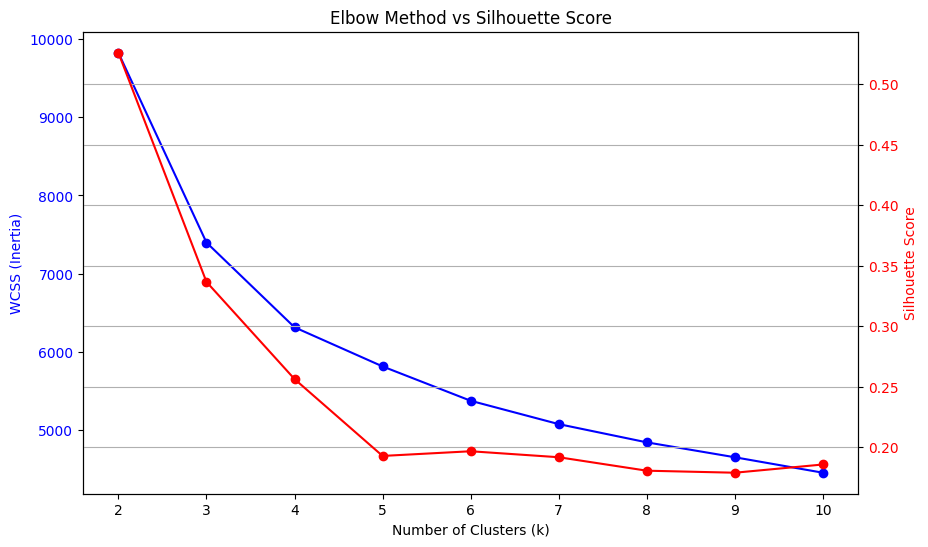

In [ ]:
hotel_profiles = df.groupby('offering_id')[['service', 'cleanliness', 'value',
                                            'location_rating', 'sleep_quality', 'rooms']].mean()

scaler = StandardScaler()
scaled_features = scaler.fit_transform(hotel_profiles)

# we find the best k using the elbow method/silhouette score
wcss = []
silhouette_avg = []
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_features)
    wcss.append(kmeans.inertia_)
    silhouette_avg.append(silhouette_score(scaled_features, cluster_labels))

fig, ax1 = plt.subplots(figsize=(10, 6))
# Plot WCSS on the left Y-axis
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('WCSS (Inertia)', color='blue')
ax1.plot(k_range, wcss, 'bo-', label='WCSS')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second Y-axis for the Silhouette Score
ax2 = ax1.twinx()
ax2.set_ylabel('Silhouette Score', color='red')
ax2.plot(k_range, silhouette_avg, 'ro-', label='Silhouette Score')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Elbow Method vs Silhouette Score')
plt.grid(True)
plt.show()

In [ ]:
# from the above we 3 or 4 clusters appear to be a good fit
# since the silhouette score takes a sharp dive after k=3,
# choosing k=4 would likely result in two segments that are too similar
# creating noise rather than distinct market segments.
# k=3 also has more business utility (like economy, business and first class)
# hence k=3 is chosen
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
hotel_profiles['cluster'] = kmeans.fit_predict(scaled_features)

cluster_performance = hotel_profiles.groupby('cluster').mean()
print("Cluster Profiles (Market Segments):")
print(cluster_performance)

Cluster Profiles (Market Segments):
         service  cleanliness  value  location_rating  sleep_quality  rooms
cluster                                                                    
0           4.34         4.47   4.18             4.38           4.25   4.18
1           2.27         2.10   2.19             2.86           2.06   1.85
2           3.64         3.69   3.59             3.85           3.48   3.33


In [ ]:
# from the performance profile, we can categorize the hotels into 3 distinct groups
# cluster 0: Premium - these hotels score consistenly high across all categories
# cluster 1: Economy - these hotels struggle across the board
# cluster 2: Mid Range - these hotels are reliable but not elite,
#                        location is the strongest, suggesting these might be
#                        well-situated but need a bit of service/room upgrade

In [ ]:
# we then merge these cluster labels back to the main df for text analysis
merged_df = df.merge(hotel_profiles[['cluster']], on='offering_id', how='left')
merged_df

,offering_id,overall,service,cleanliness,value,location_rating,sleep_quality,rooms,title,text,review_date,date_stayed,author_num_helpful_votes,cluster
0,94326,4.00,5.00,5.00,4.00,4.00,4.00,4.00,“Nice find in Boston”,"After reading past reviews, I wasn't quite sur...",2010-02-01 00:00:00,January 2010,88.00,0
1,93352,5.00,5.00,5.00,4.00,5.00,5.00,5.00,“BEST”,Great location and I was wondering if I would ...,2010-02-01 00:00:00,October 2009,25.00,0
2,93358,2.00,1.00,1.00,3.00,5.00,1.00,1.00,“Not what we really expected”,I'd found out about this hotel ages before boo...,2010-02-01 00:00:00,January 2010,25.00,0
3,84113,5.00,5.00,5.00,5.00,5.00,5.00,5.00,“Above and Beyond what you'd normally expect”,Right away we were impressed with this hotel. ...,2010-02-01 00:00:00,January 2010,31.00,2
4,502408,5.00,5.00,5.00,5.00,5.00,5.00,5.00,“Should have stuck to here all along!”,"I've stayed at this hotel twice now, once year...",2010-02-01 00:00:00,January 2010,25.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62313,1762915,4.00,5.00,5.00,3.00,5.00,4.00,4.00,“Expectations Met”,My husband and I booked a room impromptu and s...,2012-12-19 00:00:00,December 2012,27.00,0
62314,3523356,4.00,5.00,5.00,5.00,5.00,5.00,5.00,“A Four-star hotel at a Two-star price....wort...,I've stayed at plenty of Hampton Inns during m...,2012-12-19 00:00:00,December 2012,27.00,0
62315,321151,4.00,5.00,4.00,5.00,5.00,4.00,4.00,“Stay here. Here's why:”,"Ok, first of all, The Back Bay Hotel is part o...",2012-12-19 00:00:00,December 2012,132.00,0
62316,1027237,2.00,3.00,3.00,3.00,5.00,3.00,3.00,“Nothing special but beware of the downstairs ...,The king room was ok. Clean with comfortable b...,2012-12-19 00:00:00,December 2012,26.00,0


In [ ]:
# we perform some basic cleaning of the text column
merged_df['clean_text'] = merged_df['text'].str.replace(r'[^a-zA-Z\s]', '', regex=True).str.lower()
merged_df

,offering_id,overall,service,cleanliness,value,location_rating,sleep_quality,rooms,title,text,review_date,date_stayed,author_num_helpful_votes,cluster,clean_text
0,94326,4.00,5.00,5.00,4.00,4.00,4.00,4.00,“Nice find in Boston”,"After reading past reviews, I wasn't quite sur...",2010-02-01 00:00:00,January 2010,88.00,0,after reading past reviews i wasnt quite sure ...
1,93352,5.00,5.00,5.00,4.00,5.00,5.00,5.00,“BEST”,Great location and I was wondering if I would ...,2010-02-01 00:00:00,October 2009,25.00,0,great location and i was wondering if i would ...
2,93358,2.00,1.00,1.00,3.00,5.00,1.00,1.00,“Not what we really expected”,I'd found out about this hotel ages before boo...,2010-02-01 00:00:00,January 2010,25.00,0,id found out about this hotel ages before book...
3,84113,5.00,5.00,5.00,5.00,5.00,5.00,5.00,“Above and Beyond what you'd normally expect”,Right away we were impressed with this hotel. ...,2010-02-01 00:00:00,January 2010,31.00,2,right away we were impressed with this hotel t...
4,502408,5.00,5.00,5.00,5.00,5.00,5.00,5.00,“Should have stuck to here all along!”,"I've stayed at this hotel twice now, once year...",2010-02-01 00:00:00,January 2010,25.00,0,ive stayed at this hotel twice now once years ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62313,1762915,4.00,5.00,5.00,3.00,5.00,4.00,4.00,“Expectations Met”,My husband and I booked a room impromptu and s...,2012-12-19 00:00:00,December 2012,27.00,0,my husband and i booked a room impromptu and s...
62314,3523356,4.00,5.00,5.00,5.00,5.00,5.00,5.00,“A Four-star hotel at a Two-star price....wort...,I've stayed at plenty of Hampton Inns during m...,2012-12-19 00:00:00,December 2012,27.00,0,ive stayed at plenty of hampton inns during my...
62315,321151,4.00,5.00,4.00,5.00,5.00,4.00,4.00,“Stay here. Here's why:”,"Ok, first of all, The Back Bay Hotel is part o...",2012-12-19 00:00:00,December 2012,132.00,0,ok first of all the back bay hotel is part of ...
62316,1027237,2.00,3.00,3.00,3.00,5.00,3.00,3.00,“Nothing special but beware of the downstairs ...,The king room was ok. Clean with comfortable b...,2012-12-19 00:00:00,December 2012,26.00,0,the king room was ok clean with comfortable be...


In [ ]:
# to address the business problem of identifying meaningful improvement opportunities,
# this process first groups hotels into three performance tiers: Premium, Economy and Mid-Range
# based on a multi-dimensional analysis of customer ratings (i.e. the overall "experience").

# model 1: TF-IDF (not very good results - to remove)
# It then utilizes a refined TF-IDF model on aggregated review text, using tokenized stop
# words and n-grams to differentiate "Winners" from "Underperformers" by surfacing
# unique operational best practices and specific actionable gaps within each cluster.

# model 2: cosine similarity
# we then utilize consine similarity to compare the most opposing text vector of the
# "Underperformers" with the "Winners" to identify areas of improvement

In [ ]:
# we create a list of words to exclude based on iterations of TF_IDF below
# these custom words does not help us in identifying meaningful improvement opportunities
location_noise = ['san', 'francisco', 'york', 'times', 'square', 'empire', 'state',
                  'madison', 'garden', 'penn', 'station', 'park', 'convention', 'center']
generic_noise = ['hotel', 'room', 'stay', 'stayed', 'just', 'nice', 'good', 'great',
                'holiday', 'inn', 'trip', 'advisor', 'minute', 'walk', 'nights']

all_stops = list(TfidfVectorizer(stop_words='english').get_stop_words()) + location_noise + generic_noise
# setup TF-IDF with the 'Operational Filter' (Unigrams + Clean Stops)
# ensure all_stops is defined as the tokenized set of standard + location + hotel noise
tfidf = TfidfVectorizer(ngram_range=(3, 3), stop_words=all_stops, max_features=20)

# aggregate reviews on hotel level
hotel_level = merged_df.groupby('offering_id').agg(
    {**{cat: 'mean' for cat in ['service', 'cleanliness', 'value', 'location_rating', 'sleep_quality', 'rooms', 'overall']},
     'title': lambda x: " ".join(x.astype(str)), 'cluster': 'first'}).reset_index()

categories = ['service', 'cleanliness', 'value', 'location_rating', 'sleep_quality', 'rooms']
cluster_names = {0: "Premium", 1: "Economy", 2: "Mid-Range"}
final_benchmarks = {}

for cid, cname in cluster_names.items():
    final_benchmarks[cname] = {}
    subset = hotel_level[hotel_level['cluster'] == cid]

  # for cat in categories:
    # find Category Winners (Top 10%) and Losers (Bottom 10%)
    high = subset[subset["overall"] >= subset["overall"].quantile(0.90)]
    low = subset[subset["overall"] <= subset["overall"].quantile(0.10)]

    if not high.empty and not low.empty:
        docs = [" ".join(high['title']), " ".join(low['title'])]
        matrix = tfidf.fit_transform(docs).toarray()
        terms = tfidf.get_feature_names_out()

        # extract unique differentiators
        high_top = [terms[i] for i in matrix[0].argsort()[-15:][::-1]]
        low_top = [terms[i] for i in matrix[1].argsort()[-15:][::-1]]

        # store results by CATEGORY inside the cluster
        final_benchmarks[cname] = {
            "Success Drivers": [t for t in high_top if t not in low_top][:10],
            "Priority Fixes": [t for t in low_top if t not in high_top][:10]
        }

print(json.dumps(final_benchmarks, indent=4))

{
    "Premium": {
        "Success Drivers": [
            "perfect location excellent",
            "location location service",
            "home away home",
            "location wonderful staff",
            "location rooms service"
        ],
        "Priority Fixes": [
            "location location value",
            "excellent location location",
            "location helpful staff",
            "location value money",
            "location excellent place"
        ]
    },
    "Economy": {
        "Success Drivers": [
            "work progress pay",
            "want downtown austin",
            "ve decent freeway",
            "value old moldy"
        ],
        "Priority Fixes": [
            "avoid avoid avoid",
            "avoid worst motel",
            "avoid possible chain",
            "away driving modeled"
        ]
    },
    "Mid-Range": {
        "Success Drivers": [
            "home away home",
            "excellent value location",
            "service v

In [ ]:
from sentence_transformers import SentenceTransformer
EMBED_MODEL = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
print(f"Loading embedding model: {EMBED_MODEL}")
print("(This may take a minute on first run...)\n")

model = SentenceTransformer(EMBED_MODEL)

print(f"✅ Model loaded!")
print(f"   Embedding dimension: {model.get_sentence_embedding_dimension()}")

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# aggregate reviews on hotel level
hotel_level = merged_df.groupby('offering_id').agg(
    {**{cat: 'mean' for cat in ['service', 'cleanliness', 'value', 'location_rating', 'sleep_quality', 'rooms', 'overall']},
     'text': lambda x: " ".join(x.astype(str)), 'cluster': 'first'}).reset_index()

for cid, cname in {0: "Premium", 1: "Economy", 2: "Mid-Range"}.items():
    subset = hotel_level[hotel_level['cluster'] == cid]

    # 1. Split high and low performers
    high_perf = subset[subset['overall'] >= subset['overall'].quantile(0.90)]
    low_perf = subset[subset['overall'] <= subset['overall'].quantile(0.10)]

    if not high_perf.empty and not low_perf.empty:
        # 2. Vectorize individual titles for both groups
        winner_embeddings = model.encode(high_perf['text'].tolist())
        loser_embeddings = model.encode(low_perf['text'].tolist())

        # 3. Calculate similarity matrix (Losers vs Winners)
        # Shape: (num_losers, num_winners)
        sim_matrix = cosine_similarity(loser_embeddings, winner_embeddings)

        # 4. Find the "Max Similarity" for each loser
        # This tells us: "How close is this specific loser to ANY winner?"
        max_sim_per_loser = sim_matrix.max(axis=1)

        # 5. The most "Opposite" are the losers with the LOWEST max_similarity
        # They are far away from the entire winning cluster
        worst_indices = max_sim_per_loser.argsort()[:3]

        final_benchmarks[cname] = {
            "Success Definition": f"Benchmarked against {len(high_perf)} top-tier titles.",
            "Priority Fixes (Most Dissimilar)": low_perf['text'].iloc[worst_indices].tolist()
        }
print(json.dumps(final_benchmarks, indent=4))

{
    "Premium": {
        "Success Definition": "Benchmarked against 176 top-tier titles.",
        "Priority Fixes (Most Dissimilar)": [
            "The soundproofing must not be so great because I woke up every time the very energetic couple next door made love -- which was at least four times during the late night and early morning. (Congratulations to them!)\nMy room was non-smoking but there was a slight smell of smoke and I saw a trash receptacle full of butts on the public walkway outside the room.\nMetrolink trains pass by with horns blaring into the evening, but not overnight. But I am a train fan, so that was a plus for me.\nStaff people were very, very friendly and helpful. Breakfast bar in the morning looked inviting. Clean motel, free parking, nice breakfast, free business PC in lobby, convenient to most LA locations. Highly recommended.",
            "I've stayed at this location off and on for several years. I like the area of town. Unfortunately, this one time favorit